# AIM: Create a Recommendation Engine for movies for users based on there past behaviour.

## Approach used : collaborative filtering approach
### The user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.




## IMPORTING FILES

In [1]:
import pandas as pd
import numpy as np

from surprise import Reader,Dataset,SVD

##Read data to made it ready to train on
##SVD- singular model decomposition used to create recommendation system


from surprise.accuracy import rmse,mae
##use to measure error of model

from surprise.model_selection import cross_validate
##help in testing data



## Importing the Data

In [37]:
df = pd.read_csv("ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Drop column that isn't important for predications

In [38]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Check for any missing values 

In [39]:
df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

## Data exploration and analysis to analyzing data sets to get their main characteristics.

In [40]:
##no. of unique movies/users
n_movies = df["movieId"].nunique()
n_users = df["userId"].nunique()
print(f'Number of unique movies: {n_movies}')
print(f'Number of unique users: {n_users}')

Number of unique movies: 9724
Number of unique users: 610


## Checking Sparsity of our data

### Sparsity (%) = (No of missing values/ (Total Values))*100

In [41]:
available_ratings = df['rating'].count()
total_ratings = n_movies*n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings)*100
print(sparsity)

##prefer to have low sparsity to have more data to train on 

98.30003169443864


## Ratings Distribution using barplot

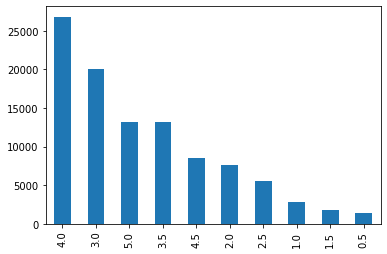

In [42]:
df['rating'].value_counts().plot(kind = 'bar')

## Dimensionality Reduction

### reducing the dimensionality of the dataset by filter out rarely rated movies and rarely rating users

#### 1. Filter movies with less than 3 ratings

In [43]:
filter_mov = df['movieId'].value_counts() > 3
filter_mov = filter_mov[filter_mov].index.tolist()

#### 2 Filter users with less than 3 movies rated

In [44]:
filter_users = df['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()

#### 3. Removing rarely rated movies and rarely rating users

In [49]:
print(f'ORIGINAL SHAPE : {df.shape}')
df = df[(df['movieId'].isin(filter_mov)) & df['userId'].isin(filter_users)]
print(f'NEW SHAPE : {df.shape}')

ORIGINAL SHAPE : (92394, 3)
NEW SHAPE : (92394, 3)


## Creating Training and Testing Datasets

#### 1. Columns used for training

In [50]:
cols = ['userId','movieId','rating']

#### 2. Creating surprise dataset

In [51]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(df[cols],reader)

#### 3. Create Train-set and Prediction-set

In [52]:
train_set = data.build_full_trainset()
antiset = train_set.build_anti_testset() # all combination of movies and users

### Creating and training the model

#### Creating the model

##### SVD (Singular Value Decomposition)   ,  Interaction Matrix = A X B X C


In [53]:
# row user
# column movie
# svd is to reduce matrix to its constitutes parts
# take sparsh matrix and multiply its factors
algo = SVD(n_epochs = 25, verbose = True)
#fit the data and go to train the data 25times (n_epochs)
#verbose : to check if traing set is working or not

### Training the model

#### Mean Absolute Error (MAE): MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.

#### Root mean squared error (RMSE): RMSE is the square root of the average of squared differences between prediction and actual observation.


In [54]:
cross_validate(algo,data,measures = ['RMSE','MAE'],cv=5, verbose = True)
print('TRAING DONE')


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

### Predictions Analysis
#### 1. Predict ratings for all pairs (user, items) that are NOT in the training set.


In [57]:
pred = algo.test(antiset)      

In [58]:
pred[0]
#user(uid) rated the movie(iid) as (est) rating , average rating of iid is r_ui,{if pred is possible or not}

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

#### 2. Recommending top 3 movies movies based on predictions

In [59]:
from collections import defaultdict
def get_top_n(pred,n):
    top_n = defaultdict(list)
    for uid,iid,_,est,_ in pred:
        top_n[uid].append((iid,est))
        
    for uid,user_ratings in top_n.items():
        user_ratings.sort(key =lambda x: x[1],reverse = True)
        top_n[uid]=user_ratings[:n]
    return top_n
    pass
top_n = get_top_n(pred,n=3)
for uid,user_ratings in top_n.items():
    print(uid,[iid for (iid,rating) in user_ratings])

1 [318, 1704, 58]
2 [1221, 858, 904]
3 [2571, 260, 899]
4 [1248, 750, 1278]
5 [1278, 1213, 914]
6 [1262, 1237, 177593]
7 [6377, 527, 2571]
8 [2959, 7361, 2502]
9 [318, 1136, 50]
10 [1246, 318, 898]
11 [1204, 3275, 1248]
12 [50, 527, 608]
13 [318, 1225, 930]
14 [1237, 922, 58559]
15 [50, 1261, 7361]
16 [1225, 898, 922]
17 [1204, 1237, 912]
18 [3508, 930, 1204]
19 [1250, 1262, 2542]
20 [1208, 912, 6377]
21 [898, 1673, 7451]
22 [527, 913, 296]
23 [72226, 34405, 38061]
24 [741, 898, 1262]
25 [1136, 1197, 1208]
26 [1172, 741, 50]
27 [89904, 2160, 2318]
28 [3972, 1193, 2288]
29 [912, 1258, 910]
30 [356, 1206, 1258]
31 [58559, 260, 1210]
32 [1136, 1193, 1204]
33 [1223, 1204, 1248]
34 [3972, 898, 32587]
35 [318, 898, 6711]
36 [1104, 1272, 750]
37 [177593, 1233, 1242]
38 [904, 1262, 1261]
39 [4878, 7153, 4993]
40 [1262, 58559, 1272]
41 [177593, 106642, 1209]
42 [2160, 1262, 1208]
43 [50, 163, 223]
44 [2583, 1197, 1252]
45 [1206, 318, 913]
46 [1237, 260, 954]
47 [94959, 7153, 1237]
48 [2160, 119